In [13]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

### Image Pre-processing

The VGG-16 model requires a 224x224 sized image with 3 channels (RGB) as input.

Steps:
1. Detect and remove corrupt images
2. Transform images to meet the requirements

In [14]:
import os
from PIL import Image

root_dir = "data/PetImages"
classes = ["Cat", "Dog"]

for cls in classes:
    folder = os.path.join(root_dir, cls)
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        try:
            with Image.open(filepath) as img:
                img.verify()  # Check for corruption
        except (IOError, SyntaxError):
            print(f"Deleting corrupted image: {filepath}")
            os.remove(filepath)


In [15]:

transform = v2.Compose([
    v2.Resize((224, 224)),  # Resizing to 224x224
    v2.ToTensor(),  # Converting to tensor
    v2.Normalize(   # Normalize using the mean and std given in the vgg16 pytorch documentation
        mean=[0.48235, 0.45882, 0.40784], 
        std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]
    )
])

train_dataset = ImageFolder("data/cats-vs-dogs/train", transform=transform)
test_dataset = ImageFolder("data/cats-vs-dogs/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 0])


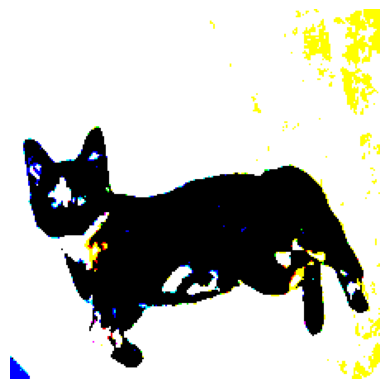

In [16]:
# Function to display an image
def imshow(tensor):
    image = tensor.numpy().transpose((1, 2, 0))  # Change from [C, H, W] to [H, W, C]
    image = np.clip(image, 0, 1)  # Clamp values to [0, 1] for display
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Show an image, its shape and labels
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    imshow(images[0])
    break

### Loading and preparing Pre-trained Model for fine-tuning

We will load the model with the pre-trained weights. Then we want to freeze the convolutional layers of the model, so we only update the fully connected layers during the fine-tuning.

In [17]:
from torchvision.models import vgg16, VGG16_Weights
import torch.nn as nn

In [18]:
model = vgg16(weights=VGG16_Weights.DEFAULT)    # Load pre-trained model with weights

# Examine the model
print(model.modules)

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2,

In [19]:
# Freeze weights of the convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier's last layer for binary classification
model.classifier[6] = nn.Linear(4096, 2)

# Move to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Check that the last layer of the classifier has changed to output 2 features (binary classification)
print(model.modules)

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2,

### Fine-tuning

For fine-tuning the model we will use CrossEntropyLoss and Adam optimizer

In [20]:
import torch.optim as optim

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [22]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()   # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)   # Data and model must be in the same device
        
        optimizer.zero_grad()   # Resets the gradients
        outputs = model(images) # Forward pass
        loss = criterion(outputs, labels)   # Compute the loss
        loss.backward() # Backward pass
        optimizer.step()    # Update model weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1/5, Loss: 270.0821, Accuracy: 87.84%
Epoch 2/5, Loss: 108.2119, Accuracy: 93.49%
Epoch 3/5, Loss: 74.9587, Accuracy: 95.69%
Epoch 4/5, Loss: 59.6572, Accuracy: 96.84%
Epoch 5/5, Loss: 48.2454, Accuracy: 97.69%


In [25]:
torch.save(model.state_dict(), 'vgg16_finetuned.pth')

In [ ]:
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        test_loss += loss.item()  # Accumulate validation loss

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total

print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


/home/carlos/fine-tuning-vision-model/.venv/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Validation Loss: 0.3166, Accuracy: 92.82%
